### **Strategy** 
The basic strategy, as its name suggests, is the simplest. There is no collaboration between agents during either the search or the transmission phase.

First, all agents move randomly in search of the targets while staying within the grid and avoiding collisions.    
At each time step, each agent evaluates all the valid actions it can take and chooses a random action from among those available.

The first agent that finds the target moves towards the command center to report the target's position.   
At each time step, it (the one that finds the target) takes the action that brings him closest to the command center while the remaining agents keep exploring the site. 

Of course, if the robot that found the target is within transmission range of the command center, he doesn't need to move.       



### **Performance**

The performance of this strategy was evaluated in terms of the number of steps needed to find the target and the number of steps needed to transmit its position. 
Monte Carlo simulation with 10 000 scenarios have been carried out to get an idea of how this strategy performs. At the beginning of each scenario, the agents and the target are randomly placed on the grid. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy import stats
from collections import Counter

## **Exogenous parameters**

In [2]:
detection_range = 2
transmission_range = 5
num_robots = 5

## **Initial Configuration**

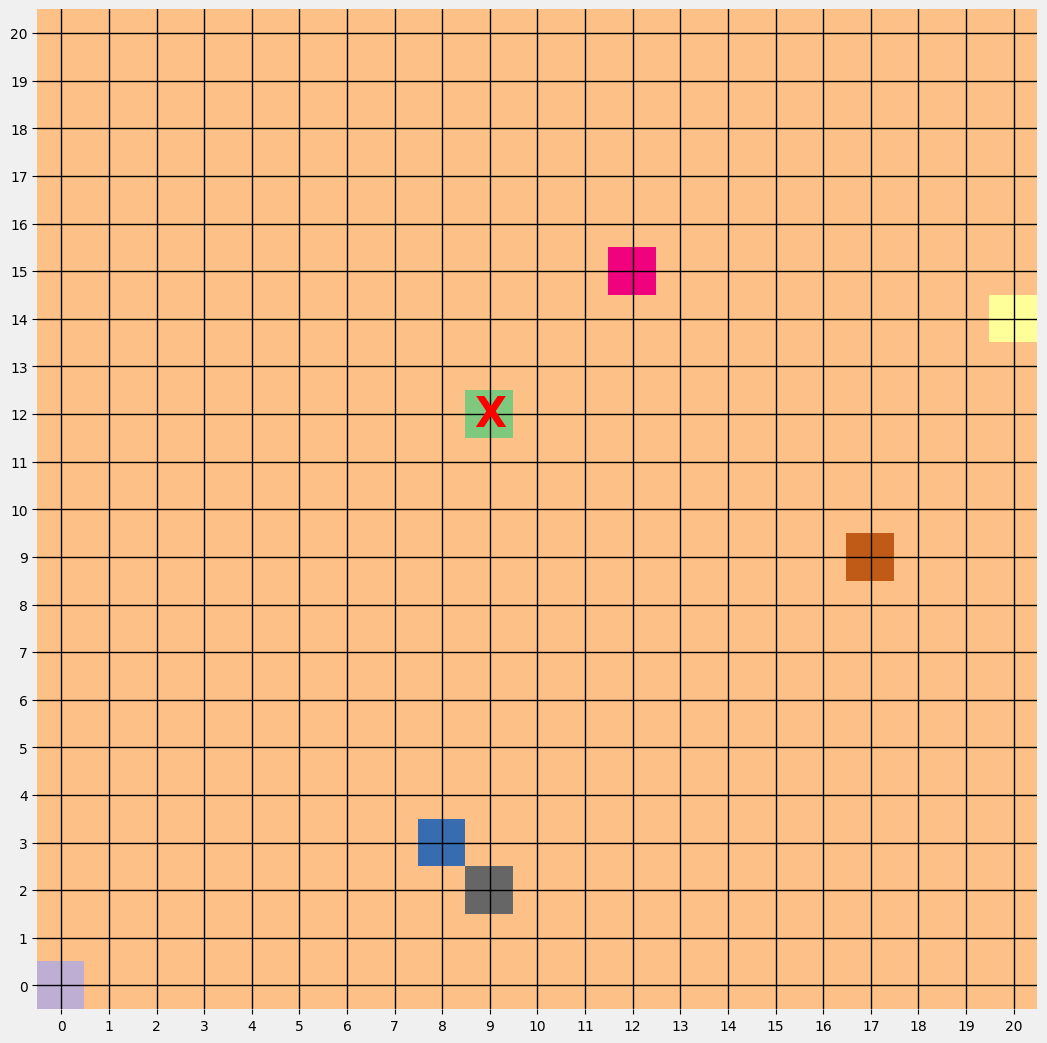

In [3]:
def place_robots(num_robots, specified_positions=None, grid_size=(21, 21)):
    
    grid = np.full(grid_size, None, dtype=object)

    # Command center at (0,0)
    grid[0, 0] = -1  # Command center is identified as -1 on the numeric grid

    
    # Unless initial positions are specified for the robots, they will be randomly generated 
    if specified_positions is not None and len(specified_positions) == num_robots:
        robot_positions = specified_positions
    else:
        # List of all unique positions on the grid
        all_positions = np.array(np.meshgrid(range(1, grid_size[0]), range(1, grid_size[1]))).T.reshape(-1, 2)
        
        # Random selection of the robots initial positions
        robot_positions = all_positions[np.random.choice(len(all_positions), size=num_robots, replace=False)]
        

    robot_names = np.arange(1, num_robots + 1)

    
    
    for position, name in zip(robot_positions, robot_names):
        grid[position[0], position[1]] = name

        
    # Generating a random position for the target
    while True:
        red_cross_position = np.random.choice(range(1, grid_size[0]), size=2)
        if grid[red_cross_position[0], red_cross_position[1]] is None:
            break


    grid_numeric = np.zeros_like(grid, dtype=int)
    grid_numeric[grid == -1] = -1  

    
    for i in range(1, num_robots + 1):
        grid_numeric[grid == i] = i

    
    grid_numeric[red_cross_position[0], red_cross_position[1]] = -2

    return grid_numeric, red_cross_position, grid_size

  
    
specified_positions = []

    
grid_result, red_cross_position, grid_size = place_robots(num_robots, specified_positions, grid_size=(21, 21))



# Displaying initial condiguration on a grid
fig = plt.figure(figsize=(10, 10), facecolor='#f0f0f0')

# Add axes to the new figure
ax = fig.add_axes([0, 0, 1, 1])
# Display the grid result with a specified colormap and extent
cax = ax.imshow(grid_result, cmap='Accent', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]])
# Hide the axes spines
ax.set_frame_on(False)

# Add grid lines for better visualization (optional)
plt.grid(True, which='both', color='black', linewidth=1)

# Set axis ticks and labels in the center of squares
plt.xticks(np.arange(0.5, grid_size[0] + 0.5, 1), np.arange(0, grid_size[0], 1))
plt.yticks(np.arange(0.5, grid_size[1] + 0.5, 1), np.arange(0, grid_size[1], 1))

ax.text(red_cross_position[1] + 0.5, red_cross_position[0] + 0.5, 'X', fontsize=30, color='r', ha='center', va='center', fontweight='bold')

# Show the plot in a pop-up window
plt.show(block=True)

In [4]:
pos_init = []
for robot in range(1, num_robots + 1):
    pos_init.append(np.argwhere(grid_result == robot)[0])

current_positions = [pos_init[robot][::-1] for robot in range(num_robots)]
current_positions

[array([20, 14]),
 array([8, 3]),
 array([12, 15]),
 array([17,  9]),
 array([9, 2])]

## **Search Phase**

Occupied positions = {(20, 14), (9, 12), (9, 2), (17, 9), (8, 3), (12, 15)}
Time Step =  1


Occupied positions = {(20, 14), (9, 12), (9, 2), (17, 9), (8, 3), (12, 15)}


Robot =  1
Current position =  [20 14]
['up', 'down', 'left', 'up left', 'down left']
New position =  [19 13]
Occupied positions = {(9, 12), (9, 2), (17, 9), (19, 13), (8, 3), (12, 15)}


Robot =  2
Current position =  [8 3]
['up', 'down', 'left', 'right', 'up left', 'up right', 'down left']
New position =  [9 4]
Occupied positions = {(9, 12), (9, 2), (17, 9), (19, 13), (12, 15), (9, 4)}


Robot =  3
Current position =  [12 15]
['up', 'down', 'left', 'right', 'up left', 'up right', 'down left', 'down right']
New position =  [13 15]
Occupied positions = {(9, 12), (9, 2), (17, 9), (19, 13), (13, 15), (9, 4)}


Robot =  4
Current position =  [17  9]
['up', 'down', 'left', 'right', 'up left', 'up right', 'down left', 'down right']
New position =  [17  8]
Occupied positions = {(9, 12), (9, 2), (19, 13), (13, 15), (17, 8), 

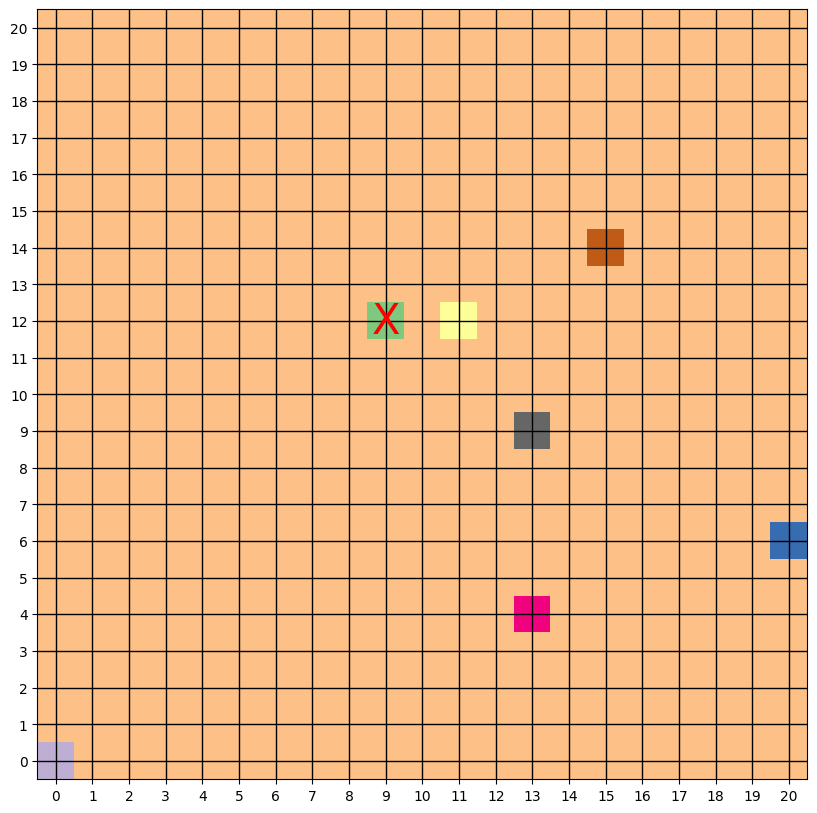

In [5]:
directions = {'up': (0, 1), 'down': (0, -1), 'left': (-1, 0), 'right': (1, 0), 'up left': (-1, 1), 'up right': (1, 1), 'down left': (-1, -1), 'down right': (1, -1)}
moves = ["up", "down", "left", "right", "up left", "up right", "down left", "down right"]



# At each time step, each agent evaluate all possible valid actions it can take (while staying within the grid and avoiding collisions) 
# Then, a random one is chosen from among those available
def get_possible_moves(pos, grid_size, occupied_positions):
    max_x, max_y = grid_size
    x, y = pos
    possible_moves = []

    for move in moves:
        new_x, new_y = x + directions[move][0], y + directions[move][1]
        if 1 <= new_x < max_x and 1 <= new_y < max_y :
            if not any(np.array_equal(pair, (new_x, new_y)) for pair in occupied_positions) :
                possible_moves.append(move)

    return possible_moves



# Keeping track of the occupied collisions to ease collisions gestion
occupied_positions = {tuple(pair) for pair in current_positions}
occupied_positions.add(tuple(red_cross_position[::-1]))
print("Occupied positions =", occupied_positions)



t = 0
target_reached = False

while not target_reached :
    
    t += 1
    
    new_positions = []
    
    found_by = np.zeros(num_robots)
    
    print("Time Step = ", t)
    print("\n")
    print("Occupied positions =", occupied_positions)
    print("\n")

    
    for robot in range(num_robots):
        print("Robot = ", robot + 1)

        current_pos = current_positions[robot]
        print("Current position = ", current_pos)

        move_choices = get_possible_moves(current_pos, grid_size, occupied_positions)
        print(move_choices)


        # If the robot is able to move safely
        if move_choices:

            new_position = tuple(np.add(current_pos, directions[random.choice(move_choices)]))

            new_positions.append(np.array(new_position))

            current_positions[robot] = np.array(new_position)
            
            grid_result[current_pos[1], current_pos[0]] = 0
            grid_result[new_positions[robot][1], new_positions[robot][0]] = robot + 1

            print("New position = ", new_positions[robot])

            occupied_positions.remove(tuple(current_pos))

            occupied_positions.add(new_position)

            print("Occupied positions =", occupied_positions)
            print("\n")
            
        # If the robot is not able to move safely, it stays on the same spot
        else:

            new_positions.append(current_pos)
            current_positions[robot] = current_pos
            print("New positions =", current_positions)
            print("Occupied positions =", occupied_positions)
            print("\n")
            
            
    # Is there an agent within detection range of the target ? 
    for robot in range(num_robots):
        if math.sqrt((new_positions[robot][0] - red_cross_position[1]) ** 2 + (new_positions[robot][1] - red_cross_position[0]) ** 2) <= detection_range:
            target_reached = True
            found_by[robot] = 1
            print("Found by robot {} : {} ".format(robot + 1, found_by[robot]))

        else:
            found_by[robot] = 0
            print("Found by robot {} : {} ".format(robot + 1, found_by[robot]))



found_by_ar = np.array(found_by)
non_null_position = np.nonzero(found_by_ar)[0][0]
target_perimeter = new_positions[non_null_position]
print("Target perimeter = ", target_perimeter)
print("\n") 


# Display the numerical version of the updated grid
print("Updated grid:")
print(grid_result)
print("\n") 
print("\n")



fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(grid_result, cmap='Accent', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]])


# Add grid lines for better visualization (optional)
plt.grid(True, which='both', color='black', linewidth=1)


# Set axis ticks and labels in the center of squares
plt.xticks(np.arange(0.5, grid_size[0] + 0.5, 1), np.arange(0, grid_size[0], 1))
plt.yticks(np.arange(0.5, grid_size[1] + 0.5, 1), np.arange(0, grid_size[1], 1))



# Display the red cross on the plot
plt.text(red_cross_position[1] + 0.5, red_cross_position[0] + 0.5, 'X', fontsize=30, color='r', ha='center', va='center')

# Show the plot in a pop-up window
plt.show(block=True)

In [6]:
current_positions2 = new_positions
current_positions2

[array([11, 12]),
 array([20,  6]),
 array([13,  4]),
 array([15, 14]),
 array([13,  9])]

## **Transmission Phase**

Occupied positions =  {(13, 4), (15, 14), (9, 12), (11, 12), (20, 6), (13, 9)}


Robot 1 needs to move to transmit the target's position


Time step =  1


Occupied positions =  {(13, 4), (15, 14), (9, 12), (11, 12), (20, 6), (13, 9)}


Robot =  1
Current position =  [11 12]
New position =  (10, 11)
Occupied positions =  {(13, 4), (10, 11), (15, 14), (9, 12), (20, 6), (13, 9)}


Robot =  2
Current position =  [20  6]
New position =  (19, 5)
Occupied positions =  {(13, 4), (10, 11), (15, 14), (9, 12), (19, 5), (13, 9)}


Robot =  3
Current position =  [13  4]
New position =  (13, 3)
Occupied positions =  {(10, 11), (15, 14), (9, 12), (13, 3), (19, 5), (13, 9)}


Robot =  4
Current position =  [15 14]
New position =  (16, 15)
Occupied positions =  {(10, 11), (9, 12), (13, 3), (13, 9), (16, 15), (19, 5)}


Robot =  5
Current position =  [13  9]
New position =  (14, 10)
Occupied positions =  {(10, 11), (9, 12), (14, 10), (13, 3), (16, 15), (19, 5)}


Robot 1 is still not now within transmi

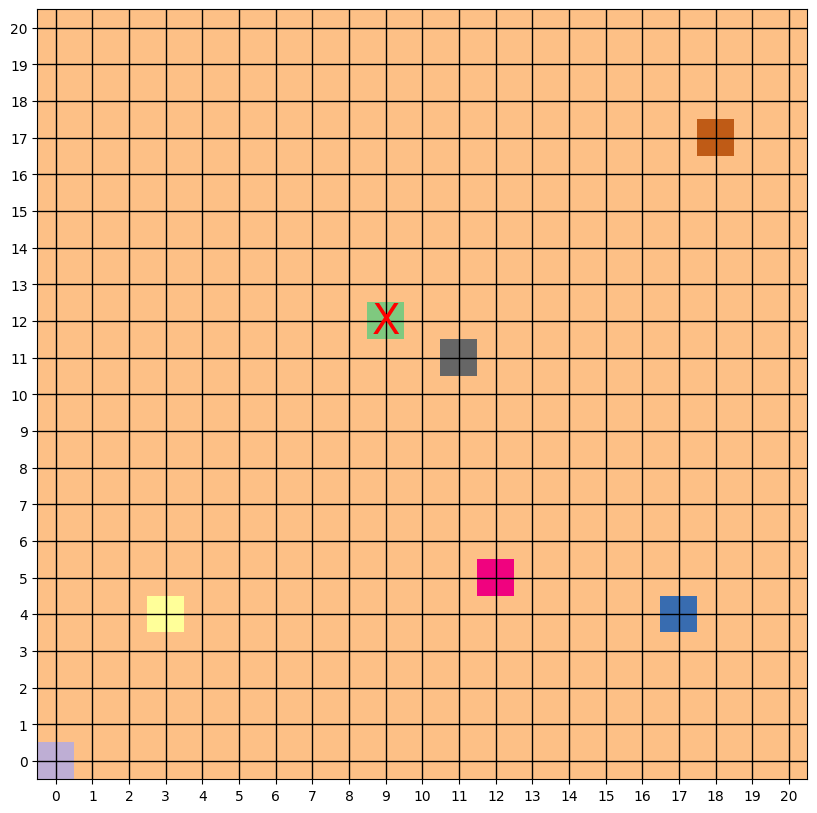

In [7]:
CC_reached = False

print("Occupied positions = ", occupied_positions)
print("\n")


# Is the agent that finds the target within transmissison range of the command center ? 
if (math.sqrt((current_positions2[non_null_position][0] - 0) ** 2 + (current_positions2[non_null_position][1] - 0) ** 2) <= transmission_range):
    CC_reached = True
    print("Robot {} is already within transmission range of the command center".format(non_null_position + 1))
    print("\n")
else :
    print("Robot {} needs to move to transmit the target's position".format(non_null_position + 1))
    print("\n")
    
    

# The agent that finds the target is not within transmissison range of the command center and needs to move towards it
p = 0

while not CC_reached :

    new_positions2 = []
    sent_by = np.zeros(num_robots)
    p += 1
    
    print("Time step = ", p)
    print("\n")
    print("Occupied positions = ", occupied_positions)
    print("\n")


    for robot in range(num_robots):
        print("Robot = ", robot + 1)

        current_pos2 = current_positions2[robot]
        print("Current position = ", current_pos2)

        # The robot that finds the target takes the first possible action that will bring it closest to the command center 
        if robot == non_null_position :

            best_move_found = False

            len_to_CC = []
            len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]

            sorted_moves = None
            sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]

            move = None
            for move in sorted_moves : 

                new_position2 = None
                new_position2 = tuple(np.add(current_pos2, directions[move]))

                if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):

                    new_positions2.append(np.array(new_position2))
                    current_positions2[robot] = np.array(new_position2)

                    best_move_found = True

                    print("New position = ", new_position2)

                    grid_result[current_pos2[1], current_pos2[0]] = 0
                    grid_result[new_position2[1], new_position2[0]] = robot + 1

                    occupied_positions.remove(tuple(current_pos2))
                    occupied_positions.add(new_position2)

                    print("Occupied positions = ", occupied_positions)
                    print("\n")

                    break

            if not best_move_found : 

                current_positions2[robot] = current_pos2
                new_positions2.append(current_pos2)
                print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                print("New position = ", new_positions2[robot])



        else : 

            move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

            if move_choices :
                new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                new_positions2.append(np.array(new_position2))
                print("New position = ", new_position2)

                current_positions2[robot] = np.array(new_position2)

                grid_result[current_pos2[1], current_pos2[0]] = 0
                grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                occupied_positions.remove(tuple(current_pos2))
                occupied_positions.add(new_position2)
                print("Occupied positions = ", occupied_positions)
                print("\n")

            else:

                new_positions2.append(current_pos2)
                current_positions2[robot] = current_pos2
                print("Move was not valid, robot {} stays on the same spot = ".format(robot + 1))
                print("New position = ", new_position2)

            

    
    # Is the agent that finds the target within transmissison range of the command center ? 
    if (math.sqrt((new_positions2[non_null_position][0] - 0) ** 2 + (new_positions2[non_null_position][1] - 0) ** 2) <= transmission_range):
        sent_by[non_null_position] = 1
        CC_reached = True
        print("Robot {} is now within transmission range of the command center". format(non_null_position + 1))
        print("\n")

    else:
        sent_by[non_null_position] = 0
        print("Robot {} is still not now within transmission range of the command center". format(non_null_position + 1))
        print("\n")
        

        
# Display the numerical version of the updated grid
print("Updated grid:")
print(grid_result)
print("\n") 
print("\n")


        
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(grid_result, cmap='Accent', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]])


# Add grid lines for better visualization (optional)
plt.grid(True, which='both', color='black', linewidth=1)


# Set axis ticks and labels in the center of squares
plt.xticks(np.arange(0.5, grid_size[0] + 0.5, 1), np.arange(0, grid_size[0], 1))
plt.yticks(np.arange(0.5, grid_size[1] + 0.5, 1), np.arange(0, grid_size[1], 1))



# Display the red cross on the plot
plt.text(red_cross_position[1] + 0.5, red_cross_position[0] + 0.5, 'X', fontsize=30, color='r', ha='center', va='center')

# Show the plot in a pop-up window
plt.show(block=True)

## **Monte Carlo Simulation**

In [8]:
number_of_steps_needed_to_approach_the_target = []
number_of_steps_needed_to_transmit_target_position_to_CC = []


# Simulation with 10 000 scenarios
for rep in range(10000) :
    
    random.seed()
    
      
    def place_robots(num_robots, specified_positions=None, grid_size=(21, 21)):
        
        grid = np.full(grid_size, None, dtype=object)

        grid[0, 0] = -1  


        if specified_positions is not None and len(specified_positions) == num_robots:
            robot_positions = specified_positions
        else:
            all_positions = np.array(np.meshgrid(range(1, grid_size[0]), range(1, grid_size[1]))).T.reshape(-1, 2)
             
            robot_positions = all_positions[np.random.choice(len(all_positions), size=num_robots, replace=False)]


        robot_names = np.arange(1, num_robots + 1)


        for position, name in zip(robot_positions, robot_names):
            grid[position[0], position[1]] = name


        while True:
            red_cross_position = np.random.choice(range(1, grid_size[0]), size=2)
            if grid[red_cross_position[0], red_cross_position[1]] is None:
                break

        
        grid_numeric = np.zeros_like(grid, dtype=int)
        grid_numeric[grid == -1] = -1  


        for i in range(1, num_robots + 1):
            grid_numeric[grid == i] = i


        grid_numeric[red_cross_position[0], red_cross_position[1]] = -2

        return grid_numeric, red_cross_position, grid_size

    
    
    specified_positions = []


    grid_result, red_cross_position, grid_size = place_robots(num_robots, specified_positions, grid_size=(21, 21))
    
    
    pos_init = []
    for robot in range(1, num_robots + 1):
        pos_init.append(np.argwhere(grid_result == robot)[0])
    
    current_positions = []
    current_positions = [pos_init[robot][::-1] for robot in range(num_robots)]
    
    
    
    
    directions = {'up': (0, 1), 'down': (0, -1), 'left': (-1, 0), 'right': (1, 0), 'up left': (-1, 1), 'up right': (1, 1), 'down left': (-1, -1), 'down right': (1, -1)}
    moves = ["up", "down", "left", "right", "up left", "up right", "down left", "down right"]
    
    
    def get_possible_moves(pos, grid_size, occupied_positions):
        max_x, max_y = grid_size
        x, y = pos
        possible_moves = []
        for move in moves:
            new_x, new_y = x + directions[move][0], y + directions[move][1]
            if 1 <= new_x < max_x and 1 <= new_y < max_y :
                if not any(np.array_equal(pair, (new_x, new_y)) for pair in occupied_positions) :
                    possible_moves.append(move)
        return possible_moves
    
    

    occupied_positions = None
    occupied_positions = {tuple(pair) for pair in current_positions}
    occupied_positions.add(tuple(red_cross_position[::-1]))


    
    # Search Phase
    t = 0
    target_reached = False    
    
    
    current_pos = None
    
    while not target_reached :
    
        t += 1
        new_positions = []
        found_by = np.zeros(num_robots)


        for robot in range(num_robots):
            
            current_pos = None
            current_pos = current_positions[robot]
            
            
            move_choices = None
            move_choices = get_possible_moves(current_pos, grid_size, occupied_positions)

            if move_choices:
                
                new_position = None
                new_position = tuple(np.add(current_pos, directions[random.choice(move_choices)]))

                new_positions.append(np.array(new_position))

                current_positions[robot] = np.array(new_position)

                grid_result[current_pos[1], current_pos[0]] = 0
                grid_result[new_positions[robot][1], new_positions[robot][0]] = robot + 1


                occupied_positions.remove(tuple(current_pos))
                occupied_positions.add(new_position)

            else:

                new_positions.append(current_pos)
                current_positions[robot] = current_pos



        for robot in range(num_robots):
            if math.sqrt((new_positions[robot][0] - red_cross_position[1]) ** 2 + (new_positions[robot][1] - red_cross_position[0]) ** 2) <= detection_range:
                target_reached = True
                found_by[robot] = 1

            else:
                found_by[robot] = 0
                
        if target_reached == True:
            number_of_steps_needed_to_approach_the_target.append(t)
        else : 
            pass



    found_by_ar = np.array(found_by)
    non_null_position = np.nonzero(found_by_ar)[0][0]
    target_perimeter = new_positions[non_null_position]
    
    
    current_positions2 = None
    current_positions2 = new_positions
    CC_reached = False
    
    
    if (math.sqrt((current_positions2[non_null_position][0] - 0) ** 2 + (current_positions2[non_null_position][1] - 0) ** 2) <= transmission_range):
        CC_reached = True
        number_of_steps_needed_to_transmit_target_position_to_CC.append(0)
        
    
    
    # Transmission phase
    p = 0

    while not CC_reached :

        new_positions2 = []
        sent_by = np.zeros(num_robots)
        p += 1


        for robot in range(num_robots):
            
            current_pos2 = None
            current_pos2 = current_positions2[robot]

            if robot == non_null_position :
                
                best_move_found = False
                
                len_to_CC = []
                len_to_CC = [np.linalg.norm(np.add(current_pos2, directions[move])) for move in moves]
                
                sorted_moves = None
                sorted_moves = [move for _, move in sorted(zip(len_to_CC, moves))]
                
                move = None
                for move in sorted_moves : 
                    
                    new_position2 = None
                    new_position2 = tuple(np.add(current_pos2, directions[move]))
                    
                    if (1 <= new_position2[0] < grid_size[0]) and (1 <= new_position2[1] < grid_size[1]) and (grid_result[new_position2[1], new_position2[0]] == 0):
                        
                        new_positions2.append(np.array(new_position2))
                        current_positions2[robot] = np.array(new_position2)
                        
                        best_move_found = True
                        
                        grid_result[current_pos2[1], current_pos2[0]] = 0
                        grid_result[new_position2[1], new_position2[0]] = robot + 1
                        
                        occupied_positions.remove(tuple(current_pos2))
                        occupied_positions.add(new_position2)
                        
                        break
                    
                if not best_move_found : 
                    
                    current_positions2[robot] = current_pos2
                    new_positions2.append(current_pos2)

            
            
            else : 
                
                move_choices = get_possible_moves(current_pos2, grid_size, occupied_positions)

                if move_choices :
                    new_position2 = tuple(np.add(current_pos2, directions[random.choice(move_choices)]))
                    new_positions2.append(np.array(new_position2))

                    current_positions2[robot] = np.array(new_position2)

                    grid_result[current_pos2[1], current_pos2[0]] = 0
                    grid_result[new_positions2[robot][1], new_positions2[robot][0]] = robot + 1


                    occupied_positions.remove(tuple(current_pos2))
                    occupied_positions.add(new_position2)

                else:

                    new_positions2.append(current_pos2)
                    current_positions2[robot] = current_pos2
                    
        
        
        if (math.sqrt((new_positions2[non_null_position][0] - 0) ** 2 + (new_positions2[non_null_position][1] - 0) ** 2) <= transmission_range):
            sent_by[non_null_position] = 1
            CC_reached = True
            number_of_steps_needed_to_transmit_target_position_to_CC.append(p)

        else:
            sent_by[non_null_position] = 0

    
    
    
avg_steps1 = np.mean(number_of_steps_needed_to_approach_the_target)
print("Average number of steps needed to find the target = ", avg_steps1)

avg_steps2 = np.mean(number_of_steps_needed_to_transmit_target_position_to_CC)
print("Average number of steps needed to transmit its position = ", avg_steps2)

Average number of steps needed to find the target =  58.9357
Average number of steps needed to transmit its position =  9.8018


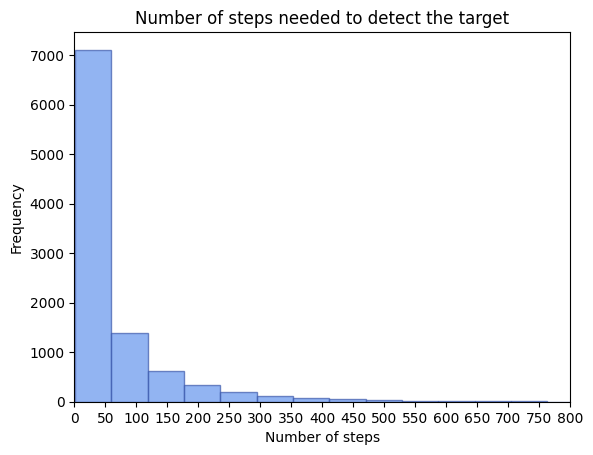

In [9]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(number_of_steps_needed_to_approach_the_target, bins=20, color="#6495ED", ec= "#3D59AB", alpha = 0.7)

ax.set_xlim([0, 800])

ech = np.arange(0, 801, 50)
etiquettes = [str(i) for i in ech]

ax.set_xticks(ech)
ax.set_xticklabels(etiquettes)

ax.set_title('Number of steps needed to detect the target')

ax.set_xlabel('Number of steps')
ax.set_ylabel('Frequency')

plt.show()

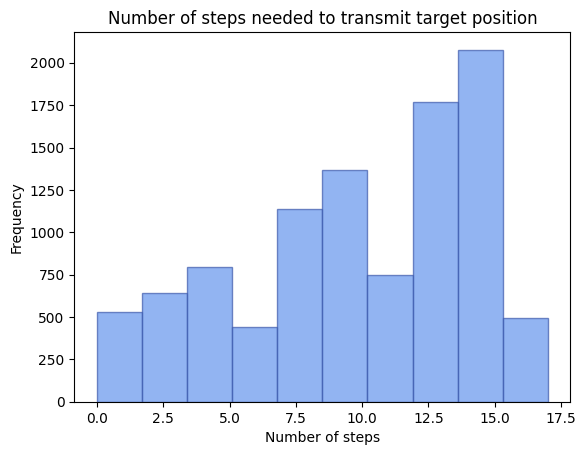

In [10]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(number_of_steps_needed_to_transmit_target_position_to_CC, color="#6495ED", ec= "#3D59AB", alpha=0.7)

ax.set_title('Number of steps needed to transmit target position')

ax.set_xlabel('Number of steps')
ax.set_ylabel('Frequency')

plt.show()

#### These histograms above show the results obtained after 10 000 applications of this basic strategy. The number of steps needed to find the target shows an asymmetry to the right. In most cases, it took 58 steps to find the target, but in the worst cases, it could take more than 400 steps before an agent gets within vision range of the target even when the initial configuration was not too bad.        


#### The number of steps needed to report the target’s position to the command center is more symmetrical. On average, it took less than 10 steps to report the target's position but the mode of the distribution is 14.       


#### But of course, to better assess the performance of this strategy, more than 10 000 scenarios will be needed.

In [11]:
stats.mode(number_of_steps_needed_to_transmit_target_position_to_CC)

ModeResult(mode=14, count=1085)

In [12]:
most_common_values = Counter(number_of_steps_needed_to_transmit_target_position_to_CC).most_common(20)

# Print the result
for value, count in most_common_values:
    print(f"Value: {value}, Count: {count}")

Value: 14, Count: 1085
Value: 15, Count: 992
Value: 13, Count: 921
Value: 12, Count: 847
Value: 11, Count: 745
Value: 10, Count: 727
Value: 9, Count: 643
Value: 8, Count: 600
Value: 7, Count: 536
Value: 16, Count: 489
Value: 6, Count: 441
Value: 5, Count: 422
Value: 4, Count: 374
Value: 3, Count: 350
Value: 0, Count: 304
Value: 2, Count: 293
Value: 1, Count: 227
Value: 17, Count: 4
